In [1]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

Note (10/27/2022):
I would like to set up an ablation study to see the effect of the following hyper parameters
on the all-class and open-set (one vs rest) F1 scores:
    - C (number of dummy classifiers)
    - beta (l1 loss coefficient determining impact of masked probability)
"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n'

In [301]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

In [302]:
NUM_CLASSES = 10
NUM_FEATURES = 784

def load_dataset():
    mndata = MNIST('/Users/jmmar/Google Drive/School/ASU/Fall 2022/EEE 598/HW2/data/')
    mndata.gz = True  # allows the use of the .gz compressed files
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, y_train = map(tensor, mndata.load_training())
    X_test, y_test = map(tensor, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = map(tensor, train_test_split(X.numpy(), y.numpy()))
    return X_train, X_val, y_train, y_val

In [349]:
X, y, X_test, y_test = load_dataset()

In [304]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [305]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, num_classes, pre_dim=50, post_dim=50, *args, **kwargs):
        super().__init__(*args, **kwargs)
        lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation=lrelu, name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation=lrelu, name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def train_SLRM(X, y, num_classes, epochs=25, plot=True, **kwargs):
    model = StandardLogisticRegressionModel( 
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        loss=ce_loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes, average='macro')]
    )
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_split=.2,
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3379 - f1: 0.9002 - val_loss: 0.1892 - val_f1: 0.9424
Epoch 2/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1606 - f1: 0.9520 - val_loss: 0.1567 - val_f1: 0.9513
Epoch 3/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1167 - f1: 0.9645 - val_loss: 0.1149 - val_f1: 0.9665
Epoch 4/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0931 - f1: 0.9719 - val_loss: 0.1077 - val_f1: 0.9686
Epoch 5/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0766 - f1: 0.9767 - val_loss: 0.1098 - val_f1: 0.9677
Epoch 6/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0658 - f1: 0.9796 - val_loss: 0.1142 - val_f1: 0.9675
Epoch 7/15
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0565 - f1: 0.9819 - val_loss: 0.0987 - val_f1: 0.9729
Epoch 8/15
1500/1500 [==============================] - 2s 2ms/step - loss: 

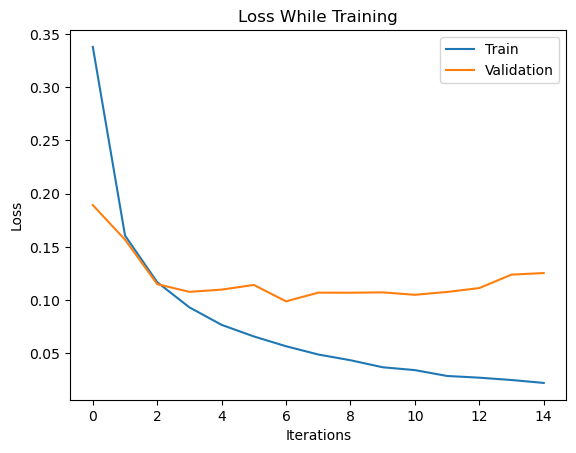

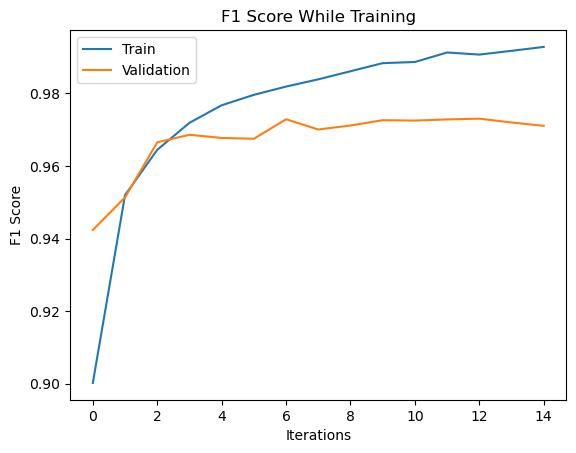

In [306]:
model = train_SLRM(X, y, num_classes=NUM_CLASSES, epochs=15, plot=True, pre_dim=50, post_dim=50)

In [307]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

Epoch 1/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.3342 - f1: 0.9021 - val_loss: 0.1946 - val_f1: 0.9435
Epoch 2/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.1531 - f1: 0.9552 - val_loss: 0.1440 - val_f1: 0.9527
Epoch 3/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.1130 - f1: 0.9660 - val_loss: 0.1072 - val_f1: 0.9668
Epoch 4/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.0872 - f1: 0.9725 - val_loss: 0.1291 - val_f1: 0.9596
Epoch 5/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.0737 - f1: 0.9769 - val_loss: 0.0926 - val_f1: 0.9717
Epoch 6/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.0606 - f1: 0.9807 - val_loss: 0.1000 - val_f1: 0.9691
Epoch 7/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.0517 - f1: 0.9831 - val_loss: 0.1063 - val_f1: 0.9683
Epoch 8/15
1014/1014 [==============================] - 2s 2ms/step - loss: 

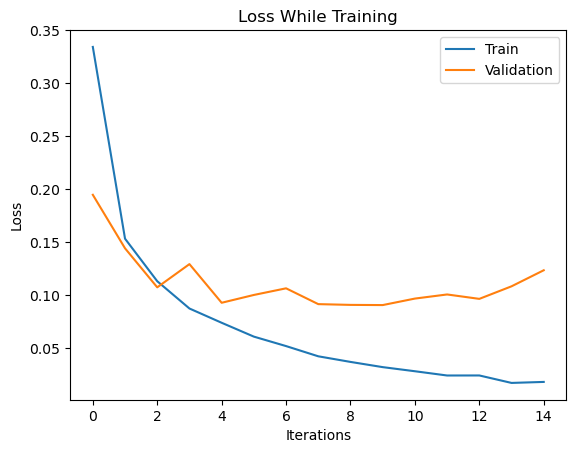

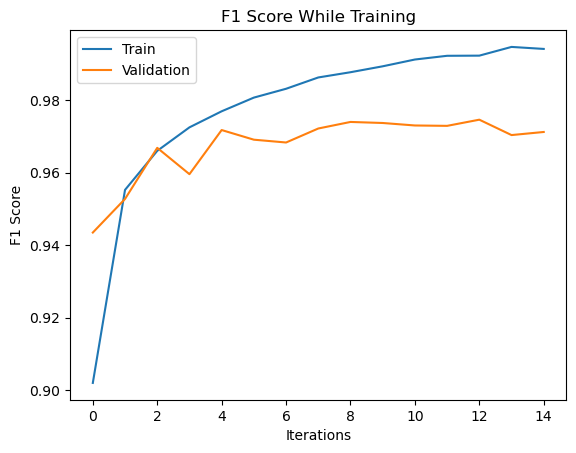

In [308]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_SLRM(
    X_train_closed, y_train_closed, 
    num_classes=NUM_CLASSES - 1, 
    epochs=15, 
    plot=True, 
    pre_dim=50, 
    post_dim=50
)

In [309]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, open_set_class_labels)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)
        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

In [310]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

tuning_metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

def tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Thresholded-Standard-Logistic-Regression model's threshold so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    threshold_values = np.linspace(0, 1, 100)
    target_known_fraction = .95
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Classification Probability Threshold'
    objective_name = 'Known Fraction'
    threshold = tune_model_param(
        model, val_closed, val_open, threshold_values, param_name, threshold_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return threshold

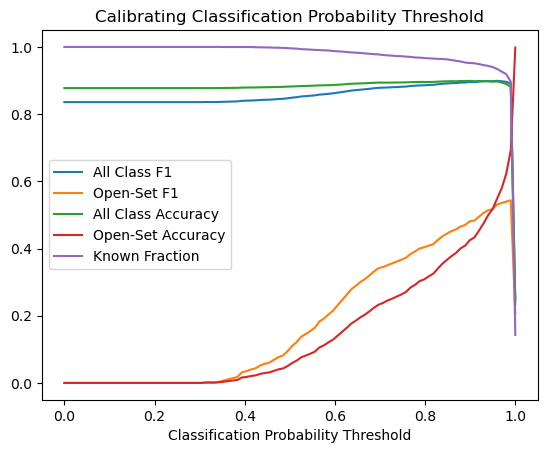

Results from test set using 95% threshold (0.9192):
All Class F1: 0.8995
Open-Set F1: 0.5011
All Class Accuracy: 0.9009
Open-Set Accuracy: 0.4579


In [311]:
threshold = tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = threshold_predict(X_test, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in tuning_metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [312]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

def train_OSPLRM(X, y, num_classes, beta=.5, epochs=25, plot=True, **kwargs):
    model = OpenSetPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    loss = lambda *x: ce_loss_for_placeholders(*x, beta)
    model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes + 1)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        X, y_train_one_hot, epochs=epochs, validation_split=.2, batch_size=32,
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.5359 - f1: 0.7069 - val_loss: 1.3774 - val_f1: 0.7910
Epoch 2/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.3284 - f1: 0.7973 - val_loss: 1.3306 - val_f1: 0.8234
Epoch 3/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.2833 - f1: 0.8236 - val_loss: 1.2859 - val_f1: 0.8242
Epoch 4/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.2565 - f1: 0.8389 - val_loss: 1.2798 - val_f1: 0.8376
Epoch 5/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.2375 - f1: 0.8486 - val_loss: 1.2757 - val_f1: 0.8331
Epoch 6/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.2249 - f1: 0.8560 - val_loss: 1.2678 - val_f1: 0.8495
Epoch 7/15
1014/1014 [==============================] - 2s 2ms/step - loss: 1.2118 - f1: 0.8626 - val_loss: 1.2583 - val_f1: 0.8506
Epoch 8/15
1014/1014 [==============================] - 2s 2ms/step - loss: 

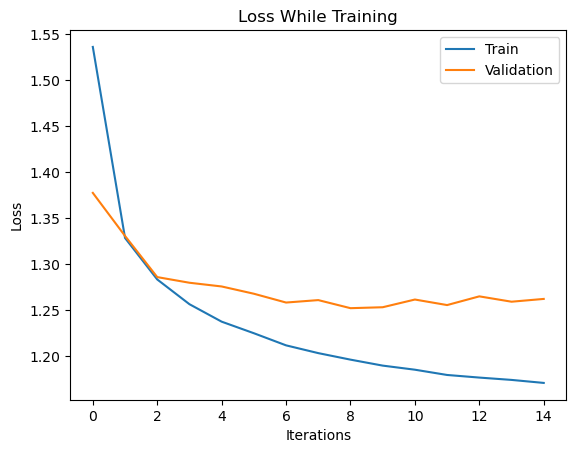

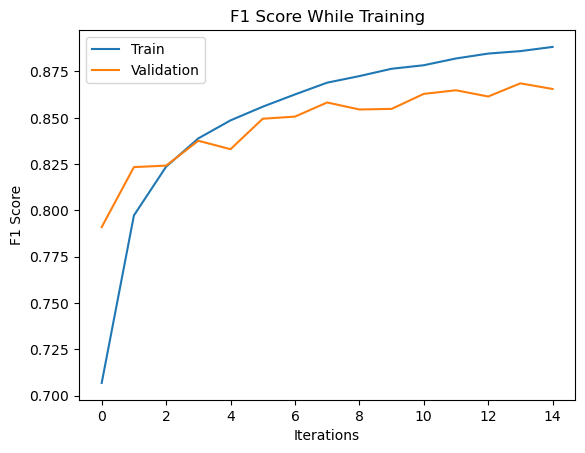

In [322]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_OSPLRM(
    X_train_closed, y_train_closed,
    num_classes=NUM_CLASSES-1,
    epochs=15,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    beta=.7,
    plot=True,
)

In [323]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Open-Set-Placeholders-Logistic-Regression model's bias so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    def placeholders_predict(X, model, bias):
        model.bias = bias
        return model.predict(X)

    target_known_fraction = .95
    bias_values = np.linspace(-2, 2, 100)
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)
    val_closed = {'X': X_val_closed, 'y': y_val_closed}
    val_open = {'X': X_val_open, 'y': y_val_open}
    param_name = 'Dummy Classifier Bias'
    objective_name = 'Known Fraction'
    bias = tune_model_param(
        model, val_closed, val_open, bias_values, param_name, placeholders_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return bias

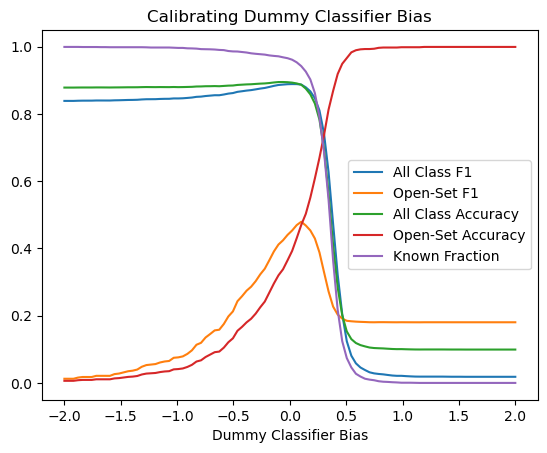

Results from test set using 95% bias (0.0606):
All Class F1: 0.8837
Open-Set F1: 0.4441
All Class Accuracy: 0.8852
Open-Set Accuracy: 0.4054


In [324]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [379]:
### THE CODE BELOW IS A WORK IN PROGRESS AND DOES NOT CURRENTLY RUN ###


"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, alpha, beta, gamma, *args, **kwargs):
        x = tf.keras.layers.Input(shape=(NUM_FEATURES,), batch_size=64)
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def train_step(self, data):
        X, y = data
        X_part1, X_part2 = tf.split(X, 2)
        y_part1, y_part2 = tf.split(y, 2)
        # create a new y_true where the true label is the open-set class
        rows, cols = y_part2.shape
        rows = rows or 1
        y_part2_new = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
        
        with tf.GradientTape() as tape:
            # caldulate the first portion of the loss on the first half of the batch
            y_part1_pred = self.call(X_part1)
            loss1 = ce_loss_for_placeholders(y_part1, y_part1_pred, self.beta)
            # perform manifold mixup and calculate the second part of the loss
            X_part2_pre = self._pre(X_part2)
            X_part2_pre_hat = self.manifold_mixup(X_part2_pre)
            y_part2_pred = self._rest(X_part2_pre_hat)
            loss2 = ce_loss(y_part2_new, y_part2_pred)
            # calculated weighted sum of losses
            loss = loss1 + self.gamma * loss2
            
        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics using the predictions from batch part 1
        self.compiled_metrics.update_state(y_part1, y_part1_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def manifold_mixup(self, X_pre):
        """
        """
        alpha = tf.constant(self.alpha)
        dist = tfp.distributions.Beta(alpha, alpha)
        lam = dist.sample(1)
        if not X_pre.shape[0]:
            return X_pre
        indices = tf.random.shuffle(tf.range(X_pre.shape[0]))
        X_pre_hat = lam * X_pre + (1 - lam) * tf.gather(X_pre, indices)
        return X_pre_hat

def train_OSPWDPLSM(X, y, num_classes, batch_size=64, epochs=25, plot=True, **kwargs):
    model = OSPWithDataPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    X_train, X_val, y_train, y_val = validation_split(X, y_train_one_hot, .2)
    # ensure the length of the training dataset is a multiple of the batch_size
    num_train_samples = (X_train.shape[0] // batch_size) * batch_size
    X_train = X_train[:num_train_samples]
    y_train = y_train[:num_train_samples]
    history = model.fit(
        X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size,
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

before:  30391
after:  30336
Epoch 1/35
474/474 [==============================] - 2s 3ms/step - f1: 0.5829 - val_loss: 0.0000e+00 - val_f1: 0.5726
Epoch 2/35
474/474 [==============================] - 1s 3ms/step - f1: 0.6787 - val_loss: 0.0000e+00 - val_f1: 0.6921
Epoch 3/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7048 - val_loss: 0.0000e+00 - val_f1: 0.7455
Epoch 4/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7210 - val_loss: 0.0000e+00 - val_f1: 0.6345
Epoch 5/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7324 - val_loss: 0.0000e+00 - val_f1: 0.7545
Epoch 6/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7440 - val_loss: 0.0000e+00 - val_f1: 0.7222
Epoch 7/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7516 - val_loss: 0.0000e+00 - val_f1: 0.7043
Epoch 8/35
474/474 [==============================] - 1s 3ms/step - f1: 0.7524 - val_loss: 0.0000e+00 - val_f1: 0.8020
Epoch 9/35
474/474 

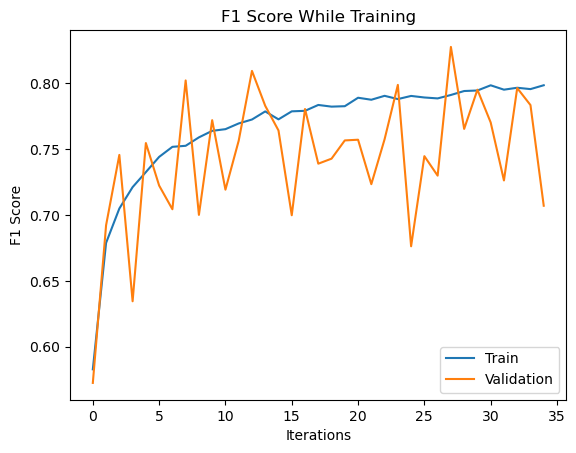

In [371]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_OSPWDPLSM(
    X_train_closed, y_train_closed,
    num_classes=NUM_CLASSES-1,
    epochs=35,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

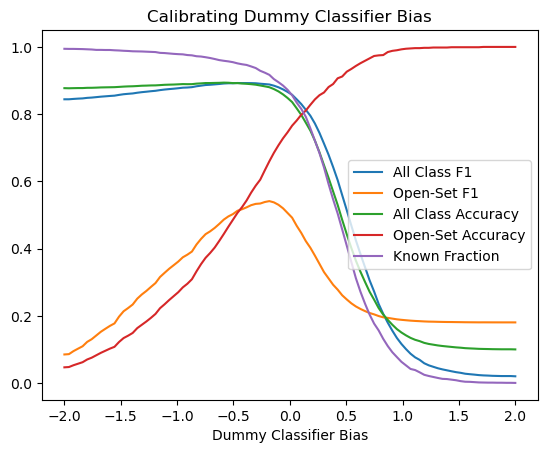

Results from test set using 95% bias (-0.4646):
All Class F1: 0.8973
Open-Set F1: 0.5350
All Class Accuracy: 0.8969
Open-Set Accuracy: 0.5183


In [372]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

Epoch 1/25
1014/1014 [==============================] - 3s 2ms/step - loss: 1.2425 - f1: 0.4856 - val_loss: 0.9891 - val_f1: 0.6491
Epoch 2/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.8506 - f1: 0.7515 - val_loss: 0.8012 - val_f1: 0.7679
Epoch 3/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.6748 - f1: 0.8264 - val_loss: 0.6454 - val_f1: 0.8376
Epoch 4/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.5683 - f1: 0.8617 - val_loss: 0.5677 - val_f1: 0.8575
Epoch 5/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.4946 - f1: 0.8805 - val_loss: 0.5134 - val_f1: 0.8782
Epoch 6/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.4434 - f1: 0.8927 - val_loss: 0.4870 - val_f1: 0.8861
Epoch 7/25
1014/1014 [==============================] - 2s 2ms/step - loss: 0.4031 - f1: 0.9051 - val_loss: 0.4583 - val_f1: 0.8909
Epoch 8/25
1014/1014 [==============================] - 2s 2ms/step - loss: 

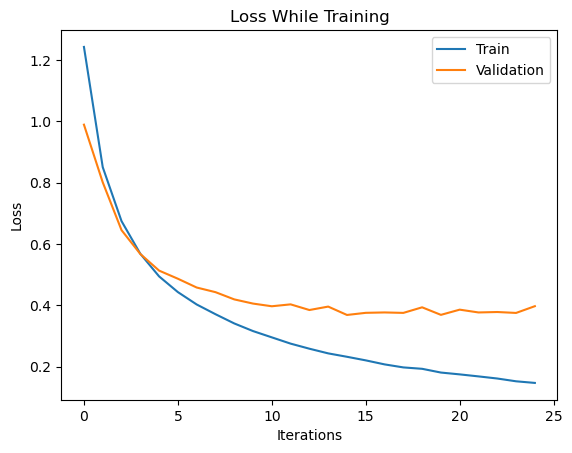

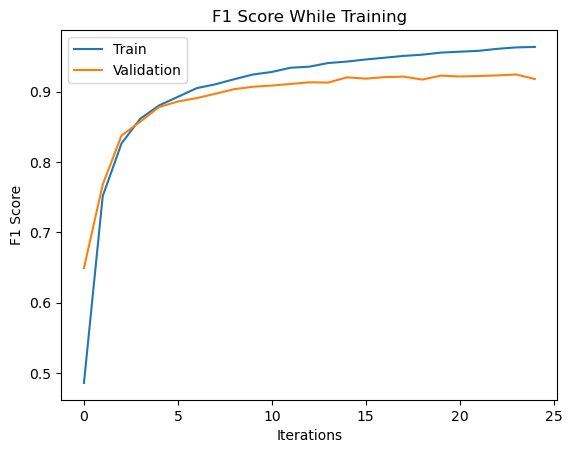

In [373]:
"""We will now look at how well the various methods separate the image embeddings by learning a 
R^d -> R^2 embedding module and plotting the various class embedding clusters.
"""

# Standard Logistic Regression trained on closed set 0-8 (9 held out)

open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_SLRM(
    X_train_closed, y_train_closed, 
    num_classes=NUM_CLASSES - 1, 
    epochs=25, 
    plot=True, 
    pre_dim=50, 
    post_dim=2
)

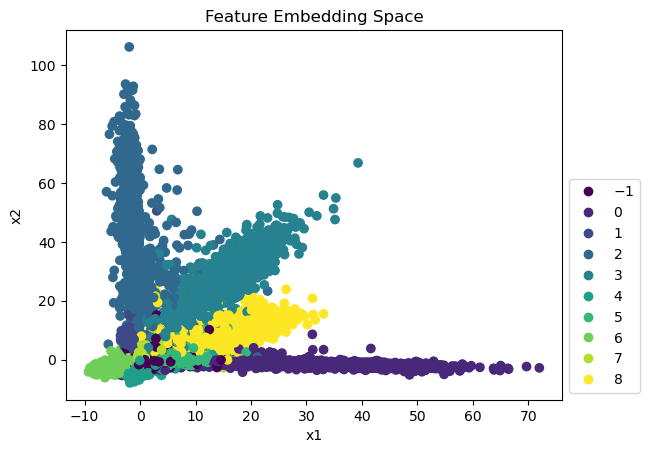

In [374]:
def plot_post_embeddings(model, X, y):
    X_pre = model.embed_pre(X)
    X_post = model.embed_post(X_pre)
    scatter = plt.scatter(X_post[:,0], X_post[:,1], c=y)
    plt.legend(*scatter.legend_elements(), loc='lower left', bbox_to_anchor=(1,0))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Feature Embedding Space')
    plt.show()

y_val_open = modify_open_set_labels(y_val, open_set_class_labels)
plot_post_embeddings(model, X_val, y_val_open)

Epoch 1/40
1015/1015 [==============================] - 3s 2ms/step - loss: 2.5187 - f1: 0.2373 - val_loss: 2.1451 - val_f1: 0.3330
Epoch 2/40
1015/1015 [==============================] - 2s 2ms/step - loss: 2.0420 - f1: 0.3405 - val_loss: 1.9502 - val_f1: 0.3600
Epoch 3/40
1015/1015 [==============================] - 2s 2ms/step - loss: 1.9008 - f1: 0.3920 - val_loss: 1.8598 - val_f1: 0.4234
Epoch 4/40
1015/1015 [==============================] - 2s 2ms/step - loss: 1.8196 - f1: 0.4555 - val_loss: 1.7971 - val_f1: 0.4725
Epoch 5/40
1015/1015 [==============================] - 2s 2ms/step - loss: 1.7584 - f1: 0.5030 - val_loss: 1.7510 - val_f1: 0.5219
Epoch 6/40
1015/1015 [==============================] - 2s 2ms/step - loss: 1.7065 - f1: 0.5401 - val_loss: 1.7179 - val_f1: 0.5554
Epoch 7/40
1015/1015 [==============================] - 2s 2ms/step - loss: 1.6630 - f1: 0.5688 - val_loss: 1.6845 - val_f1: 0.5809
Epoch 8/40
1015/1015 [==============================] - 2s 2ms/step - loss: 

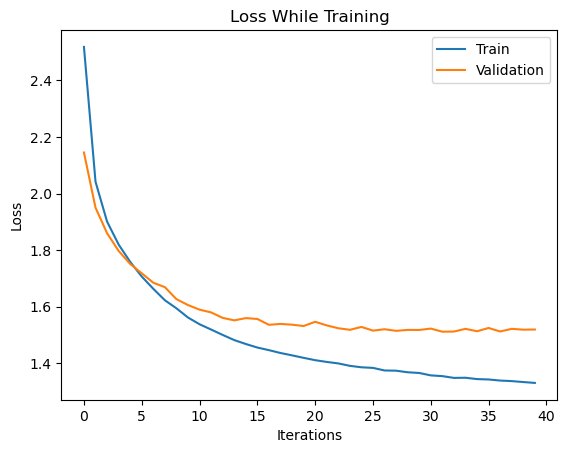

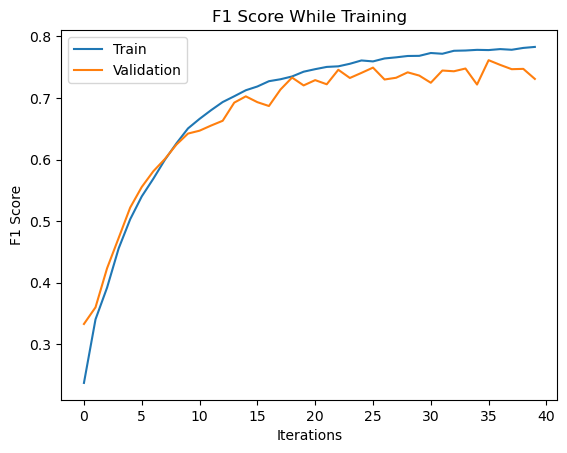

In [376]:
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_OSPLRM(
    X_train_closed, y_train_closed,
    num_classes=NUM_CLASSES-1,
    epochs=40,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    beta=.7,
    plot=True,
)

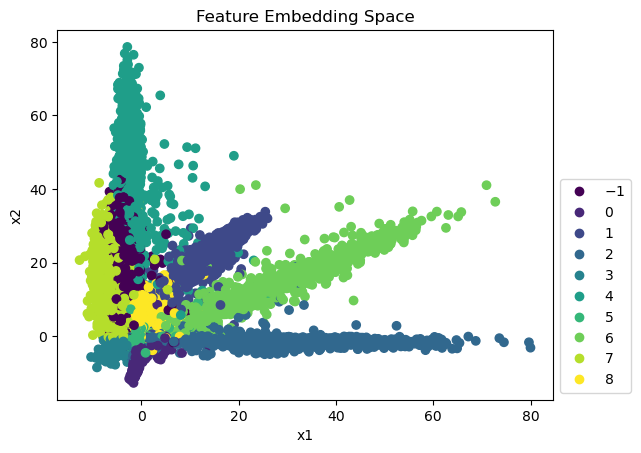

In [377]:
y_val = modify_open_set_labels(y_val, open_set_class_labels)
plot_post_embeddings(model, X_val, y_val)

Epoch 1/50
475/475 [==============================] - 2s 3ms/step - f1: 0.0244 - val_loss: 0.0000e+00 - val_f1: 0.0578
Epoch 2/50
475/475 [==============================] - 1s 3ms/step - f1: 0.1241 - val_loss: 0.0000e+00 - val_f1: 0.1775
Epoch 3/50
475/475 [==============================] - 1s 3ms/step - f1: 0.2059 - val_loss: 0.0000e+00 - val_f1: 0.1964
Epoch 4/50
475/475 [==============================] - 1s 3ms/step - f1: 0.2685 - val_loss: 0.0000e+00 - val_f1: 0.2979
Epoch 5/50
475/475 [==============================] - 1s 3ms/step - f1: 0.3259 - val_loss: 0.0000e+00 - val_f1: 0.3558
Epoch 6/50
475/475 [==============================] - 1s 3ms/step - f1: 0.3465 - val_loss: 0.0000e+00 - val_f1: 0.3242
Epoch 7/50
475/475 [==============================] - 1s 3ms/step - f1: 0.3569 - val_loss: 0.0000e+00 - val_f1: 0.3899
Epoch 8/50
475/475 [==============================] - 1s 3ms/step - f1: 0.3952 - val_loss: 0.0000e+00 - val_f1: 0.4144
Epoch 9/50
475/475 [============================

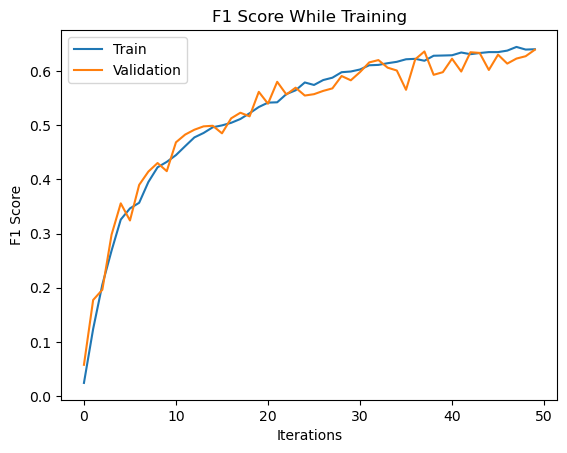

In [381]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_OSPWDPLSM(
    X_train_closed, y_train_closed,
    num_classes=NUM_CLASSES-1,
    epochs=50,
    num_placeholders=20,
    pre_dim=50,
    post_dim=2,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

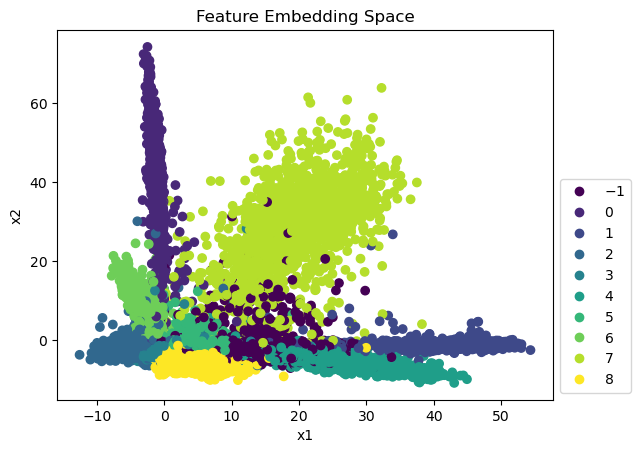

In [382]:
y_val = modify_open_set_labels(y_val, open_set_class_labels)
plot_post_embeddings(model, X_val, y_val)